<a id='introduction'></a>
## I. Introduction

Due to the launch of an upcoming marketing campaign, our e-commerce website has made plans to re-work the essential landing page of our front-end. Before our company totally commits to the change, it has been decided that the effectiveness of the new layout should be evaluated utilizing A/B hypothesis testing against the original design baseline, to determine if a significant website landing page overhaul would yield a higher conversion rate before the new marketing campaign initiative officially launches. 

<a id='first_source'></a>
As explained by Oracle<sup>[1](#1)</sup>, "A/B testing... compares the performance of two versions of content to see which one appeals more to visitors. It tests a control (a) version against a variant (b) version to measure which one is most successful based on your key metrics." After dividing our website's users randomly into either the control group (a) on the original website or the treatment group (b) on the landing page overhaul for 2 weeks, our experiment contains nearly 70,000 datapoints. Using group status and country of origin as independent features, we will proceed with an analysis to determine whether or not these elements can be used to effectively predict whether or not a guest on our website will convert to a valued customer. 
    

### Table of Contents
- [I. Introduction](#introduction)
- [II. Descriptive Statistics](#statistics)
- [III. Probability](#probability)
- [IV. Hypothesis Testing](#hypothesis)
- [V. Logistic Regression](#regression)
- [VI. Evaluation](#evaluation)
- [VII. Sources](#sources)

<a id='statistics'></a>
## II. Descriptive Statistics

We will begin by importing our external libraries into the notebook. Next, a random seed is set to ensure result reproducibility. After that, we will read in the dataset, take a look at a few rows, measure the shape of the data, the raw amount of conversions, the overall conversion rate as a percentage, and check for missing values. It will also be important to gauge the relative size of each column's unique values and visualize our guest's country of origin.

In [1]:
# import external libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm

# ensure result reproducibility
random.seed(0)

In [2]:
# read in the dataset
df = pd.read_csv('homepage_overhaul_ab_testing_data.csv')

# take a look at a few rows
df.head()

,country,group,converted
0,UK,control,0
1,US,treatment,1
2,UK,treatment,0
3,UK,control,0
4,UK,treatment,0


In [3]:
# measure the shape of the data
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

Number of rows: 69889
Number of columns: 3


In [4]:
# amount of conversions
total_conversions = df['converted'].sum()
print(f'Number of guests that converted to customers: {total_conversions}')
# conversion rate
conversion_rate = total_conversions / df.shape[0]
print(f'Percentage of guests that converted to customers: {conversion_rate*100:.2f}%')
print()

# those who did not convert
total_non_conversions = df.shape[0] - total_conversions
print(f'Number of guests that did not convert to customers: {total_non_conversions}')
# non-conversion rate
non_conversion_rate = 1 - conversion_rate
print(f'Percentage of guests that did not convert to customers: {non_conversion_rate*100:.2f}%')

Number of guests that converted to customers: 9119
Percentage of guests that converted to customers: 13.05%

Number of guests that did not convert to customers: 60770
Percentage of guests that did not convert to customers: 86.95%


In [5]:
# check for missing values
df.isna().sum()

country      0
group        0
converted    0
dtype: int64

In [6]:
# number of visitors per group
visitors_per_group = df['group'].value_counts()
visitors_per_group

treatment    35211
control      34678
Name: group, dtype: int64

In [7]:
# number of website landing page visitors per country
visitors_per_country = df['country'].value_counts()
visitors_per_country

US    48850
UK    17551
CA     3488
Name: country, dtype: int64

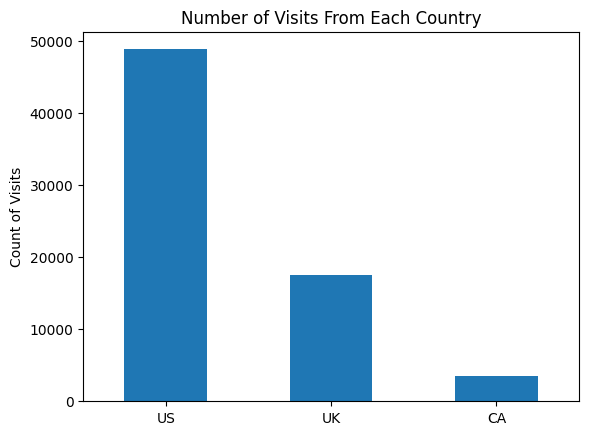

In [8]:
# visualize relative country of origin
visitors_per_country.plot(kind='bar')

# add title, add and adjust labels
plt.title('Number of Visits From Each Country')
plt.ylabel('Count of Visits')
plt.xticks(rotation=0)
plt.show();

<a id='probability'></a>
## III. Probability

Now that we're more familiar with our data, we can begin to look a little deeper. We saw above, that the overall conversion rate was 13.05%. This means that for every 100 visitors we had to our website landing page, regardless of the circustance, about 13 became customers. To be verbose and specific, we want to know precisely to what degree group identity and country of origin affect the final conversion rate. Furthermore, it will be imperative to investigate if there is a significant interaction between these two features.

In [9]:
# control conversion rate not considering country of origin
control_conversion_rate = df.query('group == "control"')['converted'].mean()
print(f'Percentage of control group that converted: {control_conversion_rate*100:.2f}%')

# treatment conversion rate not considering country of origin
treatment_conversion_rate = df.query('group == "treatment"')['converted'].mean()
print(f'Percentage of treatment group that converted: {treatment_conversion_rate*100:.2f}%')

Percentage of control group that converted: 10.53%
Percentage of treatment group that converted: 15.53%


Here, we see preliminarily that the treatment group converted 5% more often. Said another way, it seems as though a guest was roughly 1.5 times more likely to convert if they were a part of the treatment group with the new landing page overhaul for the website, compared to the baseline of the original page for the control. Let's confirm the relative group sizes.

In [10]:
# confirm the size of the control group
control_group_proportion = df.query('group == "control"').shape[0] / df.shape[0]
print(f'Percentage of guests that were in the control group: {control_group_proportion*100:.2f}%')

# and that of the treatment group 
treatment_group_proportion = df.query('group == "treatment"').shape[0] / df.shape[0]
print(f'Percentage of guests that were in the treatment group: {treatment_group_proportion*100:.2f}%')

Percentage of guests that were in the control group: 49.62%
Percentage of guests that were in the treatment group: 50.38%


Now that we know that both groups were approximately the same size, what can be said of the relative conversion rates per country of origin? This may be written as follows:

$P(\text{converted} == 1 \:|\: \text{country} == \text{"US"})$

$P(\text{converted} == 1 \:|\: \text{country} == \text{"UK"})$

$P(\text{converted} == 1 \:|\: \text{country} == \text{"CA"})$

What is the probability that a guest converted, given that its country of origin is of US, UK, and CA?

In [11]:
# find the conversion rate for each country
us_conversion_rate = df.query('country == "US"')['converted'].mean()
print(f'Percentage of guests from the US that converted: {us_conversion_rate*100:.2f}%')

uk_conversion_rate = df.query('country == "UK"')['converted'].mean()
print(f'Percentage of guests from the UK that converted: {uk_conversion_rate*100:.2f}%')

ca_conversion_rate = df.query('country == "CA"')['converted'].mean()
print(f'Percentage of guests from the CA that converted: {ca_conversion_rate*100:.2f}%')

Percentage of guests from the US that converted: 13.28%
Percentage of guests from the UK that converted: 12.51%
Percentage of guests from the CA that converted: 12.53%


Based on the above, it does not appear as though country of origin played a large factor in the outcome at this point, as each metric is within a single percentage point of the others. Next, we'll use a groupby method to striate the data across both country of origin and conversion.

In [12]:
# US conversion rate for both the control and treatment groups
df.query('country == "US"').groupby('group')['converted'].mean()

group
control      0.107314
treatment    0.157769
Name: converted, dtype: float64

In [13]:
# UK conversion rate for both the control and treatment groups
df.query('country == "UK"').groupby('group')['converted'].mean()

group
control      0.101649
treatment    0.148698
Name: converted, dtype: float64

In [14]:
# CA conversion rate for both the control and treatment groups
df.query('country == "CA"').groupby('group')['converted'].mean()

group
control      0.094474
treatment    0.154017
Name: converted, dtype: float64

When we compile this analysis together as a table, a clear trend stands out:

|             | US          | UK          | CA          |
| ----------- | ----------- | ----------- | ----------- |
| Control     | 10.73%      | 10.16%      | 9.45%       |
| Treatment   | 15.78%      | 14.87%      | 15.40%      |

This same data can also be viewed as a clustered bar chart, to show the differences discovered by the groupby method:

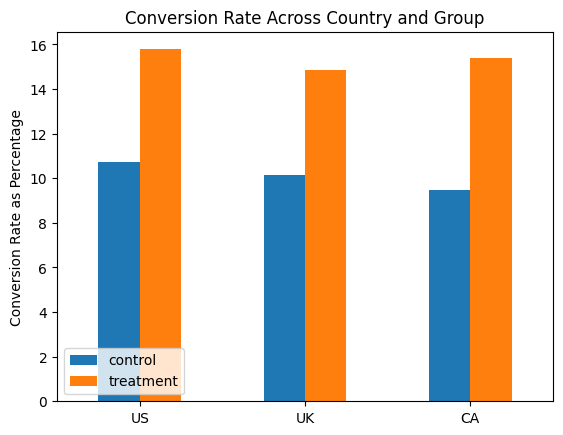

In [15]:
# manually compile data
control = [10.73, 10.16, 9.45]
treatment = [15.78, 14.87, 15.40]
index = ['US', 'UK', 'CA']

# convert to dataframe and plot
clustered_bar = pd.DataFrame({'control': control,
                              'treatment': treatment}, index=index)
clustered_bar.plot.bar()

# change legend location, add title, add and adjust labels
plt.legend(loc='lower left')
plt.title('Conversion Rate Across Country and Group')
plt.ylabel('Conversion Rate as Percentage')
plt.xticks(rotation=0)
plt.show();

The data remains within 1 percentage point for each country of origin across both groups, but each group is distinct by approximately 5 points across the board.

<a id='hypothesis'></a>
## IV. Hypothesis Testing

Now that we have laid a solid foundation for our experimentation, we can proceed with a formal hypothesis. Let us be generous and say that our standpoint, that is, the null hypothesis, is that the original website is better, or at the very least equivalent, to the new landing page. It is established, tried, true, and tested. We know it works. Then, as the challenger, only with sufficient reason and evidence should we distinguish the new version as in fact superior. This may be said as:

$H_{0}: p_{control} >= p_{treatment}$

$H_{1}: p_{control} < p_{treatment}$

Said another way, the difference in conversion rates can be said to be less than or equivalent to zero for the original website if we fail to reject the null hypothesis, or greater than zero if the null hypothesis is successfully rejected in favor of the established alternative hypothesis. Then, the experiment may be viewed in this way:

$H_{0}: p_{treatment} - p_{control} <= 0$

$H_{1}: p_{treatment} - p_{control} > 0$

Where:
- **$p_{control}$** is the `converted` rate for the original, control website page
- **$p_{treatment}$** is the `converted` rate for the new, treatment website page
- The country of origin is not distinguished

In [16]:
# for the null hypothesis, assume the same
# conversion rate for both groups, meaning
# an average of 13.05% overall
p_control_treatment_null = df['converted'].mean()
p_control_treatment_null

0.13047832992316388

In [17]:
# we can then establish the size of both 
# the control and treatment groups as they 
# are within the dataset
n_control = df.query('group == "control"').shape[0]
print(f'Control group size: {n_control}')

n_treatment = df.query('group == "treatment"').shape[0]
print(f'Treatment group size: {n_treatment}')

Control group size: 34678
Treatment group size: 35211


<a id='second_source'></a>
Python's `random.choices` function<sup>[2](#2)</sup> will provide us the opportunity to simulate `n_control` (34,678) and `n_treatment` (35,211) website events based on the overall conversion rate of 13.05% seen in `p_control_treatment_null`. The simulated event will generate a resultant list of 0's and 1's, standing for whether or not a guest converted.

To share insight from Python's magnificent documentation, `random.choices` will "Return a k sized list of elements chosen from the population with replacement. If a weights sequence is specified, selections are made according to the relative weights. If weights are not specified, selections are made with equal probability." The way weights are calculated is critical, as there is a significant difference in the proportion of those that converted (13.05%) and those that did not (1 - 13.05%, or ~86.95%). This will be seen reflected below in the function call arguments.

In [18]:
# random.choices(population, weights=None, k=1)
# random control sample
control_converted = random.choices(population = [0, 1],
                                   weights = [(1 - p_control_treatment_null),
                                               p_control_treatment_null],
                                   k = n_control)

# sample control conversion rate based on this input
p_control_convert = sum(control_converted) / df.shape[0]
print(f'Sample control conversion rate: {p_control_convert*100:.2f}%')

Sample control conversion rate: 6.51%


In [19]:
# first 5 entries of the control sample
control_converted[:5]

[0, 0, 0, 0, 0]

In [20]:
# random treatment sample
treatment_converted = random.choices(population = [0, 1],
                                     weights = [(1 - p_control_treatment_null),
                                                 p_control_treatment_null],
                                     k = n_treatment)

# sample control conversion rate based on this input
p_treatment_convert = sum(treatment_converted) / df.shape[0]
print(f'Sample treatment conversion rate: {p_treatment_convert*100:.2f}%')

Sample treatment conversion rate: 6.55%


In [21]:
# first 5 entries of the treatment sample
treatment_converted[:5]

[0, 0, 0, 0, 0]

In [22]:
# difference in estimated sample proportions between groups
# for a single sample comparison with the assumption that
# each group has the same conversion rate
p_diff = p_treatment_convert - p_control_convert
print(f'Sample difference in conversion rate between groups: {p_diff*100:.2f}%')

Sample difference in conversion rate between groups: 0.04%


Now that the structure of our experiment has been built, it can be repeated over 500 simulations for the same process. 

In [23]:
p_diffs = []

for _ in range(500):
    # each loop will simulate a single sample, like above
    control_converted = random.choices(population = [0, 1],
                                       weights = [(1 - p_control_treatment_null),
                                                   p_control_treatment_null],
                                       k = n_control)
    treatment_converted = random.choices(population = [0, 1],
                                         weights = [(1 - p_control_treatment_null),
                                                     p_control_treatment_null],
                                         k = n_treatment)
    
    # the conversion rate for each single sample is then generated
    p_control_convert = sum(control_converted) / df.shape[0]
    p_treatment_convert = sum(treatment_converted) / df.shape[0]
    
    # the difference in proportions is calculated
    p_diff = p_treatment_convert - p_control_convert
    
    # and they are compiled, composing an array entirely of 
    # the differences in proportions for each sample together as a list
    p_diffs.append(p_diff)

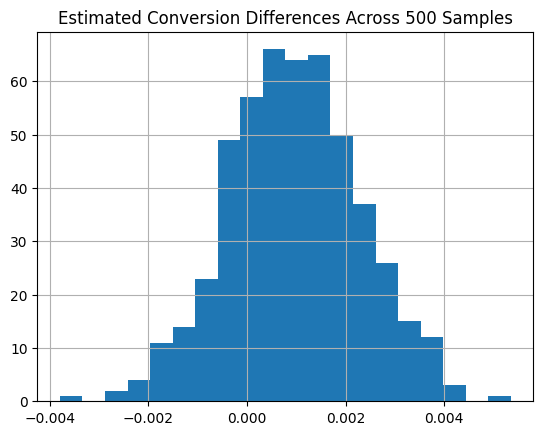

In [24]:
# convert list to pandas Series object
p_diffs = pd.Series(p_diffs)

# plot as histogram
p_diffs.hist(bins=20);
plt.title('Estimated Conversion Differences Across 500 Samples');

In [25]:
# means of differences
print(f'Average sample difference in conversion rates across 500 cycles: {p_diffs.mean()*100:.2f}%')

Average sample difference in conversion rates across 500 cycles: 0.10%


The proportion of sample `p_diffs` that are greater than the actual observed difference seen in the `control` and `treatment` groups from the collected data can now be compared.

In [26]:
# actual difference between groups seen in data
p_diff_actual = treatment_conversion_rate - control_conversion_rate
print(f'Actual percentage difference seen in data: {p_diff_actual*100:.2f}%')
print(f'Seen as a complete proportion: {p_diff_actual}')

Actual percentage difference seen in data: 5.01%
Seen as a complete proportion: 0.050066728877864425


<a id='third_source'></a>
According to Western Michigan University<sup>[3](#3)</sup>, a probability value may be defined and explained as, "The probability of obtaining test results at least as extreme as the result actually observed, under the assumption that the null hypothesis is correct. Assuming the null hypothesis is true, what do the sample data say about how likely the null hypothesis is to be true? When viewed in the context of this question, a p-value is more simply the probability to which the data support the null hypothesis. Accordingly, a large p-value lends support to the assertion of a correct null hypothesis. Hence, larger p-values result in failure to reject the null hypothesis. Conversely, a small p-value means that there is a lesser chance that the data support the null hypothesis. A p-value doesn’t tell you if the null hypothesis is true or false. It just tells you how likely it would be to obtain a particular result (from sample data) if the null hypothesis were true. A p-value is a piece of evidence, not a definitive proof." 

In [27]:
# the amount of estimated sample differences that 
# are greater than the actual difference seen in the data
p_value = (p_diffs > p_diff_actual).sum()
p_value

0

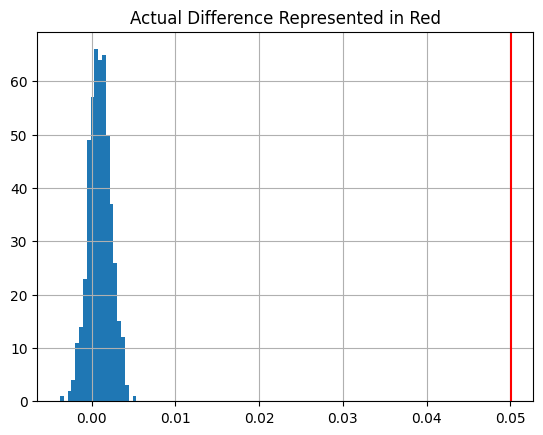

In [28]:
# original histogram seen above
p_diffs.hist(bins=20);

# where the actual difference seen in the data between
# both groups is visually when compared to the distribution
# of the 500 sample iterations
plt.axvline(p_diff_actual, color='red');
plt.title('Actual Difference Represented in Red');

To recapitulate once more for clarity, above we computed the proportion of the probability differences in the 500 sample iterations that are greater than the actual observed difference between the treatment and control groups in the original dataframe. When taking into consideration the standard Type I error rate of 0.05, also known as "alpha," we see that the findings in the original data may be seen as statistically significant, and that the null hypothesis may be rejected. 

The average difference between the groups across 500 sample iterations is seen in the blue distribution demonstrated by the histogram above. The actual difference shown in the data is far removed from the constraint of the null hypothesis as the red vertical bar. The p-value of 0, far below the alpha of 0.05, represents this numerical rejection of the null hypothesis that the original control website has a greater, or at the very least, equivalent, conversion rate when compared to the new treatment landing page.

<a id='regression'></a>
## V. Logistic Regression

<a id='fourth_source'></a>
We can confirm that the null hypothesis is successfully rejected with another method. Below, we will implement an established algorithm that will model data under the hood. According to Penn State<sup>[4](#4)</sup>, "Logistic Regression models a relationship between predictor variables and a categorical response variable. It helps us estimate a probability of falling into a certain level of the categorical response given a set of predictors. A binary response has two possible outcomes. Examples of binary responses could include passing or failing a test, responding yes or no on a survey, and having high or low blood pressure." It is used to predict the chance that a feature vector should be labelled as a certain category; it shows the probability that a data entry is a given class. Explaining the details of the mathematics behind this algorithm any further is beyond the scope of this project. 

Said simply, our visitors either converted into customers, or they did not. Using this algorithm, we will be able to test the previous experiment in another way to evaluate the associated probability value. For the following implementation, we will create an intercept for the algorithm, generate a one-hot encoded column to represent the categorical variable `group`, and split our data into `X` for our independent predictor feature variable and `y` for the dependent target variable. The model will then be instantiated and trained, with the probability value evaluated against the previous sampling probability value that was done. This process may be done for just the group, leaving out country of origin for now in order to hold the same features accountable as was previously done in the sampling.

In [29]:
# create an intercept column for the algorithm
df['intercept'] = 1

# map the categorical variable group as control: 0, treatment: 1
df['ab_page'] = pd.get_dummies(df['group'])['treatment']

# show a few rows of the new dataframe
df.head()

,country,group,converted,intercept,ab_page
0,UK,control,0,1,0
1,US,treatment,1,1,1
2,UK,treatment,0,1,1
3,UK,control,0,1,0
4,UK,treatment,0,1,1


In [30]:
# split the data into independent and dependent features
X = df[['intercept', 'ab_page']]
y = df['converted']

# build and fit the logistic regression model 
lr_model = sm.Logit(y, X)
lr_results = lr_model.fit()

Optimization terminated successfully.
         Current function value: 0.384516
         Iterations 6


In [31]:
# repeat the probability value for the previous sampling
print(f'Previous Sampling Probability Value: {p_value}')

# return the new probability value for comparison
print(f'Logistic Regression Probability Value to five decimal places: {lr_results.pvalues[1]:.5f}')

Previous Sampling Probability Value: 0
Logistic Regression Probability Value to five decimal places: 0.00000


<a id='evaluation'></a>
## VI. Evaluation

We can see here that the logistic regression model agrees with the sampling process: the probability value is less than the standard Type I error rate, alpha, of 0.05. This enables us to successfully reject the null hypothesis that the original control website landing page is better than or the same as the new treatment page in favor of the alternative hypothesis. 

The difference seen in the pages may be considered statistically significant, and it will be worth publishing the new website landing page for the upcoming marketing campaign. Something key to consider, is that if this was a change that was more costly in terms of time, energy, labor, or payroll than simply publishing a previously created website page, the yield may not be practically significant depending on the situation.

Admittedly, this dataset has its own limitations. There is a small set of feature vector columns that could be used as independent variables. The overall number of data points is rudimentary. Without a primary key or specific indicator, duplicate values are unable to be adequately assessed. It was previously compiled, and lacks any missing values. Due to these constraints, a more robust experiment would need to be established in order to handle the rigor of a more complex dataset.

<a id='sources'></a>
## VII. Sources

<a id='1'></a>
[[1]](#first_source): [What is A/B testing?](https://www.oracle.com/cx/marketing/what-is-ab-testing/)

<a id='2'></a>
[[2]](#second_source): [random - Generate pseduo-random numbers](https://docs.python.org/3/library/random.html)

<a id='3'></a>
[[3]](#third_source): [P-Values Simplified](https://wmed.edu/sites/default/files/P-VALUES%20SIMPLIFIED.pdf)

<a id='4'></a>
[[4]](#fourth_source): [Logistic Regression](https://online.stat.psu.edu/stat462/node/207/)

This dataset and project originated from and was inspired by Udacity's [Statistics for Data Analysis](https://www.udacity.com/course/statistics-for-data-analysis-nanodegree--nd588) Nanodegree. Within each certificate program, theory is demonstrated through conceptual explanations in written language, programmatic exercises to implement said concepts in code, pseudo-code interpretations bridging spoken human language and algorithms, and pure mathematical notation. Skills and abilities are exemplified in projects that are submitted and graded against an established rubric.